<a href="https://colab.research.google.com/github/donw385/DS-Unit-4-Sprint-4-Deep-Learning/blob/master/module3-generative-adversarial-networks/LS_DS_443_Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Generative Adversarial Networks

![This Person Does Not Exist](https://thispersondoesnotexist.com/image)

# Lecture

## A plot made for Hollywood

Meet Gene:

![Gene Wilder](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Gene_Wilder_1970.JPG/379px-Gene_Wilder_1970.JPG)

Gene is the clever sort, and occasionally a bit mischievous. His goal is to **generate** things that trick Val:

![Val Kilmer](https://upload.wikimedia.org/wikipedia/commons/2/22/Val_Kilmer_Cannes.jpg)

Val has a simple job, but he takes it seriously - he wants to **validate** the authenticity of things that tricky Gene passes his way. Overall, Gene is a forger, and Val is a detective.

And as with all great mystery dramas, Gene and Val are essentially playing a sort of game. They compete, and in doing so drive each other to improve.

Considered as a GAN, Gene is the generator, and Val is the discriminator.

## *Two* neural networks - adversaries!

![Spy vs. Spy](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Comikaze_Expo_2011_-_Spy_vs_Spy_%286325381362%29.jpg/360px-Comikaze_Expo_2011_-_Spy_vs_Spy_%286325381362%29.jpg)

Generative Adversarial Networks is an approach to unsupervised learning, based on the insight that we can train *two* networks simultaneously and pit them against each other.

- The discriminator is trained with real - but unlabeled - data, and has the goal of identifying whether or not some new item belongs in it.
- The generator starts from noise (it doesn't see the data at all!), and tries to generate output to fool the discriminator (and gets to update based on feedback).

GANs can be considered a zero-sum game, in the [game theory](https://en.wikipedia.org/wiki/Game_theory) sense. Game theory is a common approach to modeling strategic competitive behavior between rational decision makers, and is heavily used in economics as well as computer science.

If you've also heard the hype about [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning), one way to understand it is:

```
Reinforcement Learning : GAN :: Decision Theory : Game Theory
```

That is, Reinforcement Learning is more closely analogous to [decision theory](https://en.wikipedia.org/wiki/Decision_theory), a relative to the field of game theory, featuring the behavior of an "agent" against "nature" (the environment). The agent is strategic and rational, but the environment simply is.

## A Foray into Game Theory

What is a "zero sum" game? It is a model of the interaction of two strategic agents, in a situation where, for one to gain, the other must lose, and vice-versa.

A famous example is the [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner's_dilemma). The typical story behind this game is something like this:

> Two criminals who committed a crime together are caught by the authorities. There is enough evidence to put them each away for 3 years, but the police interrogate them separately, and offer each of them a deal - "Tell us what the other criminal did, and we'll go lighter on you."

> The deal is tempting - the person who takes it shaves 2 years off their sentence. But, it adds 5 years to the sentence of the other person. So if both talk, they both get 3 - 2 + 5 = 6 years, twice as much if they both don't. But if one talks and the other doesn't, the talker gets 1 year and the non-talker gets 8!

> The result is, individually, they both prefer defecting (talking with the police) regardless of what the other person does. But, they'd both be better off if they could somehow trust one another to not talk to the police.

Mathematically, we consider this outcome a *Nash equilibrium* - a stable situation where neither player would want to unilaterally change strategy. But, it's one where a *pareto superior* outcome exists (an outcome that both players would prefer to what they have now).

An illustration (with different numbers) of the Prisoner's Dilemma:

![Prisoner's Dilemmat](https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/Dilema_do_Prisioneiro.png/480px-Dilema_do_Prisioneiro.png)

More generally, these could be referred to as "constant sum" games - "zero sum" implies that for any player to get ahead, the other must inevitably end up behind. The above illustration could be of a game where people are "splitting loot", and so everybody *gets* something - it's just that some get more than others. The utility can be normalized so it sums to zero, or any other constant.

Game Theory is one of the core tools used in social science and other areas to model and explain behavior. The main path to overcome "dilemmas" is *iteration* - through repetition, players can have a reputation, and value that reputation more than the outcome in any single round. For example, think of the lengths some restaurants take to ensure positive reviews.

*Exercise* - think of at least two scenarios that could be explained with Prisoner's Dilemma, and of one other scenario that you think could also be modeled as some sort of strategic game between agents.

## Minimum Viable GAN

Courtesy of Keras:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # performance timing

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [0]:
np.random.seed(10)
random_dim = 100
 
def load_minst_data():
    # load the data - we'll use Fashion MNIST, for a change of pace
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [0]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=784,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
 
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

4423680/4422102 [==============================] - 0s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


  0%|          | 0/937 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
Instructions for updating:
Use tf.cast instead.


  1%|          | 9/937 [00:00<00:11, 83.92it/s]

--------------- Epoch 2 ---------------


  1%|          | 9/937 [00:00<00:10, 89.46it/s]

--------------- Epoch 3 ---------------


  1%|          | 10/937 [00:00<00:09, 99.66it/s]

--------------- Epoch 4 ---------------


  1%|          | 10/937 [00:00<00:09, 97.27it/s]

--------------- Epoch 5 ---------------


  1%|          | 10/937 [00:00<00:09, 98.32it/s]

--------------- Epoch 6 ---------------


  1%|          | 11/937 [00:00<00:09, 99.33it/s]

--------------- Epoch 7 ---------------


  1%|          | 11/937 [00:00<00:09, 100.19it/s]

--------------- Epoch 8 ---------------


  1%|          | 11/937 [00:00<00:09, 100.59it/s]

--------------- Epoch 9 ---------------


  1%|          | 11/937 [00:00<00:09, 100.91it/s]

--------------- Epoch 10 ---------------


  1%|          | 9/937 [00:00<00:10, 88.20it/s]

--------------- Epoch 11 ---------------


  1%|          | 11/937 [00:00<00:09, 100.35it/s]

--------------- Epoch 12 ---------------


  1%|          | 11/937 [00:00<00:09, 101.21it/s]

--------------- Epoch 13 ---------------


  1%|          | 10/937 [00:00<00:09, 97.98it/s]

--------------- Epoch 14 ---------------


  1%|          | 10/937 [00:00<00:09, 99.72it/s]

--------------- Epoch 15 ---------------


  1%|          | 11/937 [00:00<00:09, 100.93it/s]

--------------- Epoch 16 ---------------


  1%|          | 10/937 [00:00<00:09, 98.19it/s]

--------------- Epoch 17 ---------------


  1%|          | 11/937 [00:00<00:09, 101.20it/s]

--------------- Epoch 18 ---------------


  1%|          | 9/937 [00:00<00:10, 88.53it/s]

--------------- Epoch 19 ---------------


  1%|          | 10/937 [00:00<00:09, 96.88it/s]

--------------- Epoch 20 ---------------


  1%|          | 9/937 [00:00<00:11, 84.11it/s]

--------------- Epoch 21 ---------------


  1%|          | 10/937 [00:00<00:09, 99.91it/s]

--------------- Epoch 22 ---------------


  1%|          | 10/937 [00:00<00:09, 96.19it/s]

--------------- Epoch 23 ---------------


  1%|          | 11/937 [00:00<00:09, 101.52it/s]

--------------- Epoch 24 ---------------


  1%|          | 10/937 [00:00<00:09, 99.55it/s]

--------------- Epoch 25 ---------------


  1%|          | 10/937 [00:00<00:09, 99.12it/s]

--------------- Epoch 26 ---------------


  1%|          | 11/937 [00:00<00:09, 101.00it/s]

--------------- Epoch 27 ---------------


  1%|          | 9/937 [00:00<00:10, 88.34it/s]

--------------- Epoch 28 ---------------


  1%|          | 9/937 [00:00<00:10, 85.81it/s]

--------------- Epoch 29 ---------------


  1%|          | 11/937 [00:00<00:09, 100.22it/s]

--------------- Epoch 30 ---------------


  1%|          | 10/937 [00:00<00:09, 99.71it/s]

--------------- Epoch 31 ---------------


  1%|          | 10/937 [00:00<00:09, 94.53it/s]

--------------- Epoch 32 ---------------


  1%|          | 11/937 [00:00<00:09, 101.17it/s]

--------------- Epoch 33 ---------------


  1%|          | 10/937 [00:00<00:10, 92.67it/s]

--------------- Epoch 34 ---------------


  1%|          | 10/937 [00:00<00:09, 99.74it/s]

--------------- Epoch 35 ---------------


  1%|          | 9/937 [00:00<00:10, 87.45it/s]

--------------- Epoch 36 ---------------


  1%|          | 10/937 [00:00<00:09, 99.89it/s]

--------------- Epoch 37 ---------------


  1%|          | 11/937 [00:00<00:09, 101.34it/s]

--------------- Epoch 38 ---------------


  1%|          | 11/937 [00:00<00:09, 101.49it/s]

--------------- Epoch 39 ---------------


  1%|          | 10/937 [00:00<00:09, 99.64it/s]

--------------- Epoch 40 ---------------


100%|██████████| 937/937 [00:09<00:00, 99.01it/s]


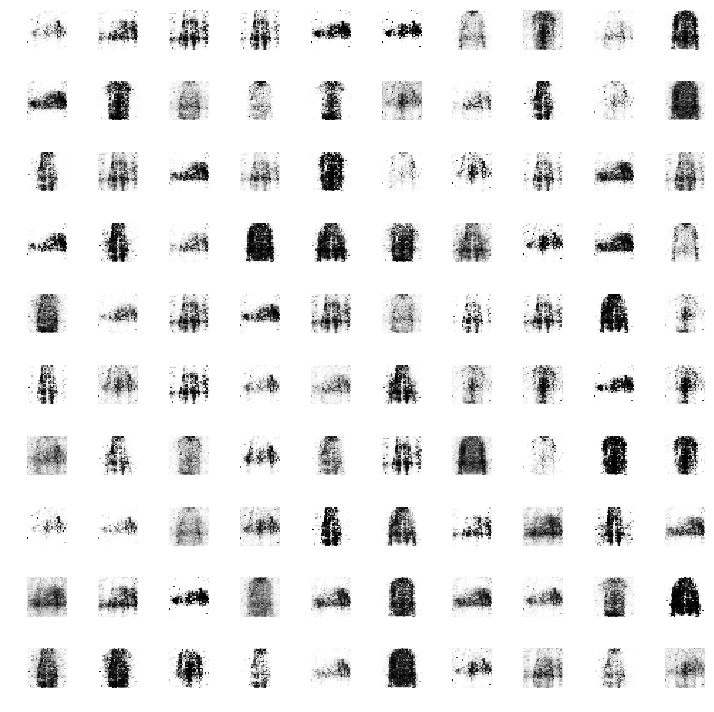

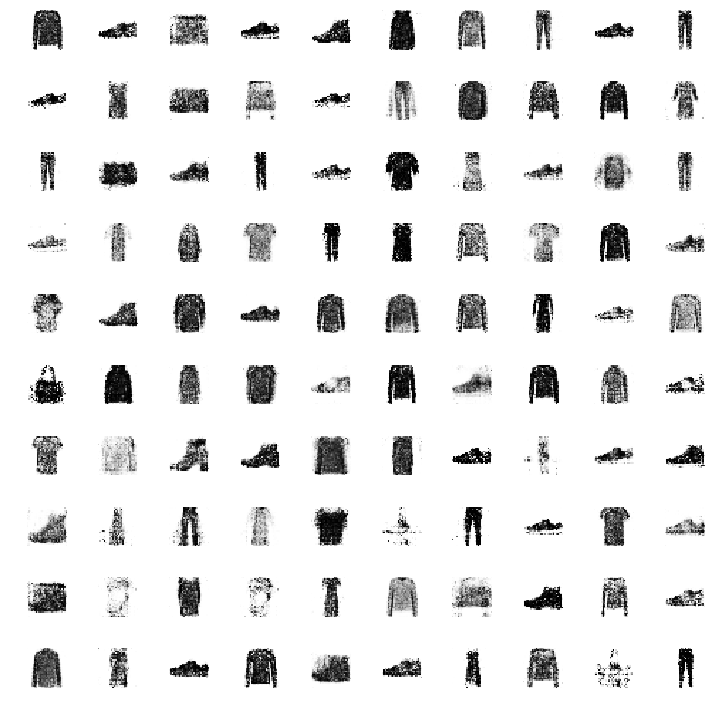

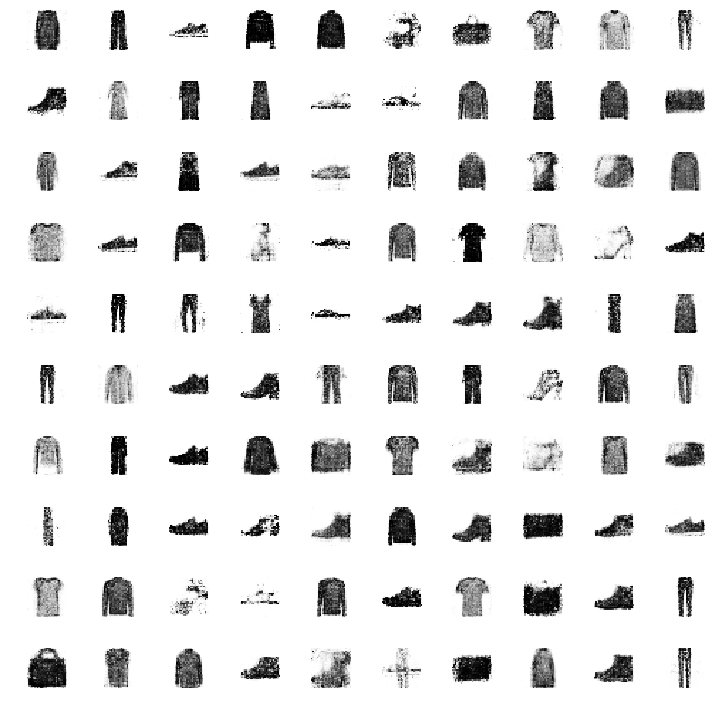

In [4]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)]
 
            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
 
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
 
train(40, 64)

Pretty decent results, even after not too many iterations.

We can do even better, with pretrained StyleGAN!

## StyleGAN - A Style-Based Generator Architecture for Generative Adversarial Networks

Original paper: https://arxiv.org/abs/1812.04948

Source code: https://github.com/NVlabs/stylegan

Many applications:
- https://thispersondoesnotexist.com
- https://thiscatdoesnotexist.com
- https://thisairbnbdoesnotexist.com
- https://stackroboflow.com

In [5]:
!git clone https://github.com/NVlabs/stylegan
%cd stylegan/

Cloning into 'stylegan'...
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (77/77), done.
/content/stylegan


In [6]:
# From stylegan/pretrained_example.py

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

def main():
    # Initialize TensorFlow.
    tflib.init_tf()

    # Load pre-trained network.
    url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
    with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
        _G, _D, Gs = pickle.load(f)
        # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
        # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
        # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

    # Print network details.
    Gs.print_layers()

    # Pick latent vector.
    rnd = np.random.RandomState(5)
    latents = rnd.randn(1, Gs.input_shape[1])

    # Generate image.
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)

    # Save image.
    os.makedirs(config.result_dir, exist_ok=True)
    png_filename = os.path.join(config.result_dir, 'example.png')
    PIL.Image.fromarray(images[0], 'RGB').save(png_filename)

main()


Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/latents_in            -         (?, 512)             -               
G_mapping/labels_in             -         (?, 0)               -               
G_mapping/PixelNorm             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656 

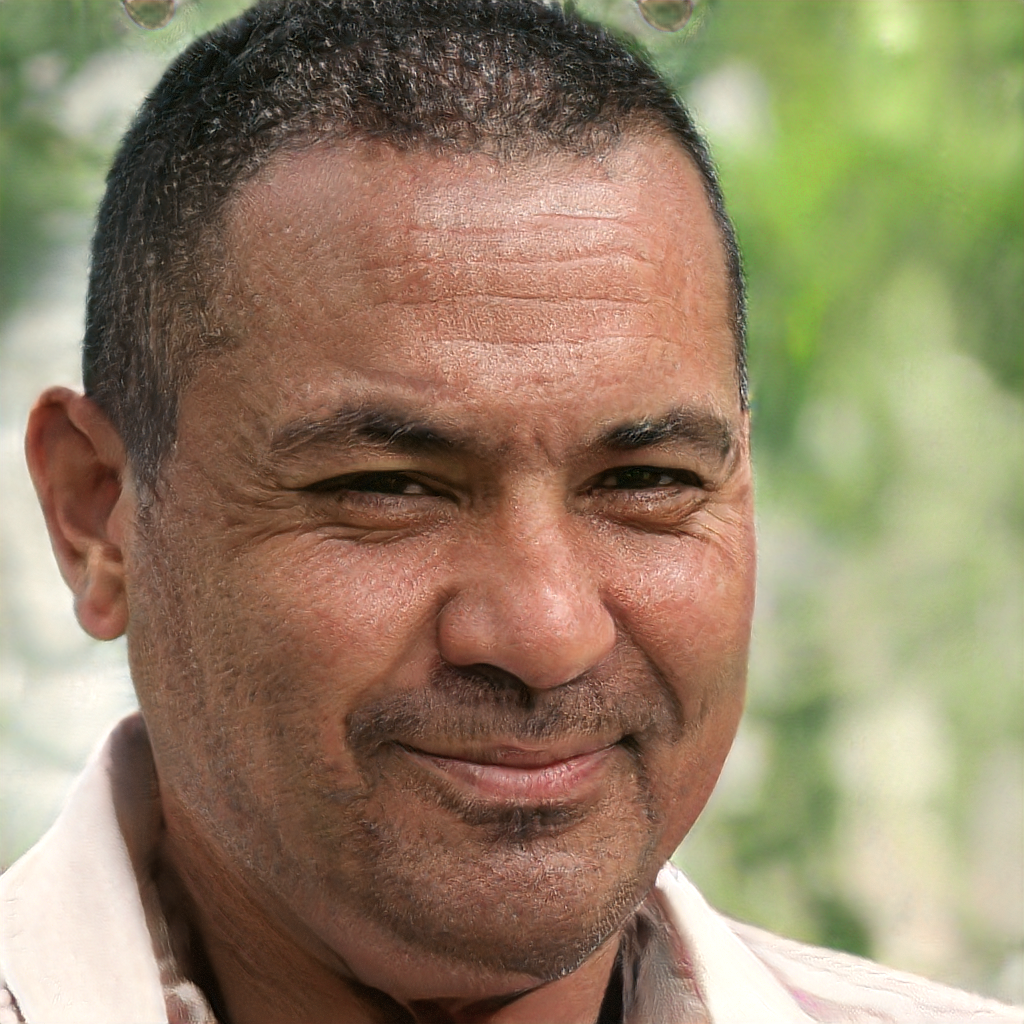

In [0]:
from IPython.display import Image
Image(filename='results/example.png')

# Assignment - ⭐ EmojiGAN ⭐

Using the provided "minimum viable GAN" code, train a pair of networks to generate emoji. To get you started, here's some emoji data:

In [7]:
!pip install emoji_data_python

     |████████████████████████████████| 81kB 9.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/ce/50/87/ae01673e45b9bd9c826a1b868a0e5a6b856e2e52cdf0f81c0d
Successfully built emoji-data-python


In [8]:
!wget https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
!unzip emoji.zip

--2019-05-16 15:08:06--  https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/master/module3-generative-adversarial-networks/emoji.zip [following]
--2019-05-16 15:08:07--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/master/module3-generative-adversarial-networks/emoji.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3407395 (3.2M) [application/zip]
Saving to: ‘emoji.zip’

emoji.zip           100%[=

In [0]:
import imageio
import matplotlib.pyplot as plt
from skimage import color

example_emoji = imageio.imread('emoji/1f683.png')
grayscale_emoji = color.rgb2gray(example_emoji)

In [10]:
example_emoji.shape

(28, 28, 4)

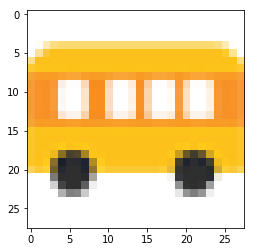

In [11]:
plt.imshow(example_emoji);

In [12]:
grayscale_emoji.shape

(28, 28)

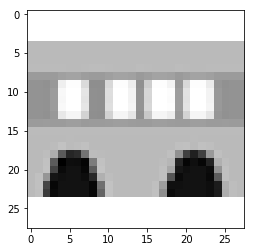

In [13]:
plt.imshow(grayscale_emoji, cmap="gray");

**Your goal** - *train a GAN that makes new emoji!*

The good news - the data is naturally 28x28, which is the same size as the earlier example (resulting in an input layer size of $28 \times 28=784$). It's big enough to kinda look like a thing, but small enough to be feasible to train with limited resources.

The bad news - the emoji are 4 layer PNGs (RGBA), and grayscale conversion is inconsistent at best (the above looks pretty good, but experiment and you'll see). It's OK to convert to grayscale and train that way to start (since it'll pretty much drop in to the example code with minimal modification), but you may want to see if you can figure out handling all 4 layers of the input image (basically - growing the dimensionality of the data).

The worse news - this dataset may not be large enough to get the same quality of results as MNIST. The resources/stretch goals section links to additional sources, so feel free to get creative (and practice your scraping/ingest skills) - but, it is suggested to do so only *after* working some with this as a starting point.

*Hint* - the main challenge in getting an MVP running will just be loading and converting all the images. [os.listdir](https://docs.python.org/3.7/library/os.html#os.listdir) plus a loop, and refactoring the image processing code into a function, should go a long way.

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # performance timing

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers
import imageio
import matplotlib.pyplot as plt
from skimage import color

example_emoji = imageio.imread('emoji/27a1.png')


In [15]:
example_emoji.shape


(28, 28, 4)

In [16]:

example_emoji = np.expand_dims(example_emoji, axis=0)
example_emoji.shape

(1, 28, 28, 4)

In [0]:
np.random.seed(10)
random_dim = 100
 
def load_emoji_data():
  
  x_train = np.empty((28, 28, 4))
  x_train = np.expand_dims(x_train, axis=0)
  
  # Load the image and convert to np.array 
  for image in os.listdir('emoji'):
    emoji_array = imageio.imread('emoji/'+image)
    x_train = np.concatenate((x_train,
                                  emoji_array[np.newaxis,:,:]),axis=0)
  
  print(x_train.shape)
  x_train = (x_train.astype(np.float32) - 127.5)/127.5
  # convert x_train with a shape of (862, 28, 28, 4) to (862, 3136) so we have
  # 3136 columns per row
  x_train = x_train.reshape(862, 3136)
  
  return x_train

In [0]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=3136,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(3136, activation='tanh'))
    # generator.add(Dense(3136, activation='sigmoid'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28, 4)
 
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow((generated_images[i]*255).astype(np.uint8), 
                   interpolation='nearest', cmap='gray_r')
        # plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

(862, 28, 28, 4)


  0%|          | 0/26 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 60.79it/s]

--------------- Epoch 2 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 65.94it/s]

--------------- Epoch 3 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 66.77it/s]

--------------- Epoch 4 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 68.88it/s]

--------------- Epoch 5 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 67.37it/s]

--------------- Epoch 6 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 64.76it/s]

--------------- Epoch 7 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 66.53it/s]

--------------- Epoch 8 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 66.79it/s]

--------------- Epoch 9 ---------------


 23%|██▎       | 6/26 [00:00<00:00, 59.79it/s]

--------------- Epoch 10 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 62.52it/s]

--------------- Epoch 11 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 62.76it/s]

--------------- Epoch 12 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 61.67it/s]

--------------- Epoch 13 ---------------


 23%|██▎       | 6/26 [00:00<00:00, 58.38it/s]

--------------- Epoch 14 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 61.61it/s]

--------------- Epoch 15 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 60.88it/s]

--------------- Epoch 16 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 60.82it/s]

--------------- Epoch 17 ---------------


 23%|██▎       | 6/26 [00:00<00:00, 56.49it/s]

--------------- Epoch 18 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 62.43it/s]

--------------- Epoch 19 ---------------


 27%|██▋       | 7/26 [00:00<00:00, 63.95it/s]

--------------- Epoch 20 ---------------


100%|██████████| 26/26 [00:00<00:00, 61.06it/s]


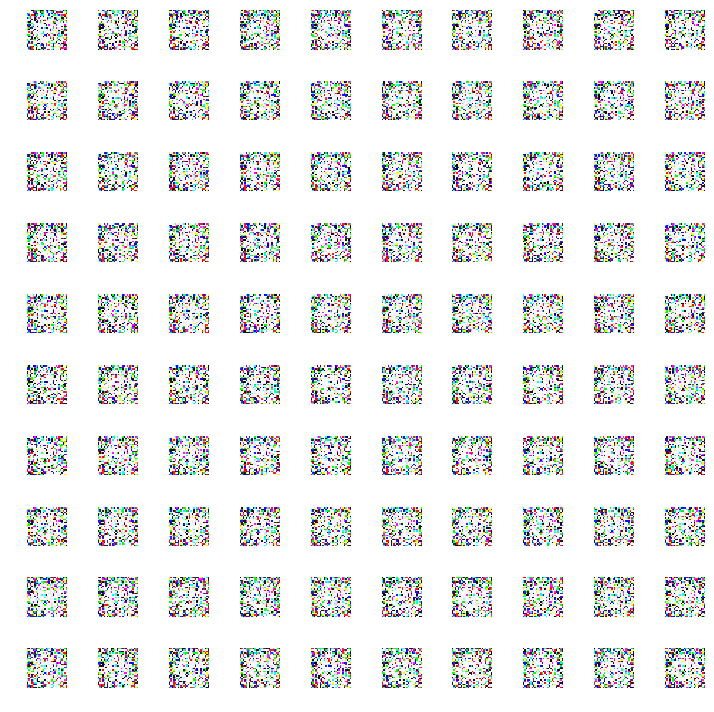

In [19]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train = load_emoji_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)]
 
            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
 
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 40 == 0:
            plot_generated_images(e, generator)
 
train(20, 32)


# Resources and Stretch Goals

Stretch goals
- [emoji-data](https://github.com/iamcal/emoji-data) - more, bigger, emoji
- [Slackmojis](https://slackmojis.com) - even more - many of them animated, which would be a significant additional challenge (probably not something for a day)

Resources
- [StyleGAN Explained](https://towardsdatascience.com/explained-a-style-based-generator-architecture-for-gans-generating-and-tuning-realistic-6cb2be0f431) - blog post describing GANs and StyleGAN in particular
- [Implementing GANs in TensorFlow](https://blog.paperspace.com/implementing-gans-in-tensorflow/) - blog post showing TF implementation of a simple GAN
- [Training GANs using Google Colaboratory](https://towardsdatascience.com/training-gans-using-google-colaboratory-f91d4e6f61fe) - an approach using Torch and GPU instances
- [Gym](https://gym.openai.com) - a toolkit for reinforcement learning, another innovative ML approach
- [deep emoji generative adversarial network](https://github.com/anoff/deep-emoji-gan) - yes, the idea of an emoji GAN has been done - so check out this extended analysis of the results
- [DeepMoji](http://deepmoji.mit.edu) - not a GAN, but a cool application of deep learning to emoji